In [1]:
import sys
import os
import pandas as pd
sys.path.append('../../../py_pkg')
import platform_designer as qpd
import pd_ip.pd_ip as pd_ip
from pd_ip.custom_ips import sec_works_aes
import pd_ip.quartus_ips as quartus_ips
from analysis import tunable_tdc_sweeper as tts

In [2]:
# import Quartus Platform Designer system as instance objects
sopcinfo_header = os.path.abspath("../../../../EXPERIMENTS/build_scripts/tdc_sec_works_aes/work/qsys_headers/hps_0.h")
pd_0 = qpd.pd_system("u0", [sopcinfo_header], 0xC0000000, "/dev/mem")
# initialize all modules and setup MMIO
pd_0.initialize(True)

Imported from /root/PL-Sensor-Intel/EXPERIMENTS/build_scripts/tdc_sec_works_aes/work/qsys_headers/hps_0.h
COMPONENT_NAME: DMA_to_SDRAM
	CSR_COMPONENT_TYPE : altera_msgdma
	COMPONENT_TYPE : altera_msgdma
	CSR_COMPONENT_NAME : DMA_to_SDRAM
	CSR_BASE : 64
	CSR_SPAN : 32
	CSR_END : 95
	CSR_IRQ : 1
	CSR_BURST_ENABLE : 1
	CSR_BURST_WRAPPING_SUPPORT : 1
	CSR_CHANNEL_ENABLE : 0
	CSR_CHANNEL_ENABLE_DERIVED : 0
	CSR_CHANNEL_WIDTH : 8
	CSR_DATA_FIFO_DEPTH : 2048
	CSR_DATA_WIDTH : 256
	CSR_DESCRIPTOR_FIFO_DEPTH : 32
	CSR_DMA_MODE : 2
	CSR_ENHANCED_FEATURES : 0
	CSR_ERROR_ENABLE : 0
	CSR_ERROR_ENABLE_DERIVED : 0
	CSR_ERROR_WIDTH : 8
	CSR_MAX_BURST_COUNT : 8
	CSR_MAX_BYTE : 65536
	CSR_MAX_STRIDE : 1
	CSR_PACKET_ENABLE : 0
	CSR_PACKET_ENABLE_DERIVED : 0
	CSR_PREFETCHER_ENABLE : 0
	CSR_PROGRAMMABLE_BURST_ENABLE : 0
	CSR_RESPONSE_PORT : 2
	CSR_STRIDE_ENABLE : 0
	CSR_STRIDE_ENABLE_DERIVED : 0
	CSR_TRANSFER_TYPE : Full Word Accesses Only
	DESCRIPTOR_SLAVE_COMPONENT_TYPE : altera_msgdma
	DESCRIPTOR_SLAVE_

In [3]:
# setup DMA *TODO* convert to python module - currently a C driver
dma = os.open("/dev/msgdma_tdc", os.O_RDONLY)
pd_0.pd_ip_insts["DMA_to_SDRAM"].dma_fh=dma

In [4]:
# Connect reset PIOs to proper instances
pd_0.pd_ip_insts["theta_pll_reconfig"].reset_pio = pd_0.pd_ip_insts["theta_pll_reset_pio"]
pd_0.pd_ip_insts["phi_pll_reconfig"].reset_pio = pd_0.pd_ip_insts["phi_pll_reset_pio"]
pd_0.pd_ip_insts["pulsegenerator"].reset_pio = pd_0.pd_ip_insts["tdc_reset_pio"]
# Connect locked PIOs to PLLs
pd_0.pd_ip_insts["theta_pll_reconfig"].locked_pio = pd_0.pd_ip_insts["theta_locked"]
pd_0.pd_ip_insts["phi_pll_reconfig"].locked_pio = pd_0.pd_ip_insts["phi_locked"]
# Configure PLL number of outputs
pd_0.pd_ip_insts["theta_pll_reconfig"].num_out = 2
pd_0.pd_ip_insts["phi_pll_reconfig"].num_out = 1

In [5]:
# Import PLL configs for sweep
theta_pll_configs = "../pll_configs/theta.csv"
theta_cfg_params = pd.read_csv(theta_pll_configs)
phi_pll_configs   = "../pll_configs/phi.csv"
phi_cfg_params = pd.read_csv(phi_pll_configs)

In [6]:
# Snipped from AES-HD dataset
aes_key  = [0x2b7e1516, 0x28aed2a6, 0xabf71588, 0x09cf4f3c]
aes_ctxt = [0x6bc1bee2, 0x2e409f96, 0xe93d7e11, 0x7393172a]

# AES has no direct interface, so create an instance manually
aes_ip_dict = {
    "COMPONENT_NAME" : "sec_works_aes_inst",
    "COMPONENT_TYPE" : "sec_works_aes",
    "BASE" : 0x000,
    "SPAN" : 0x000,
    "END"  : 0x000
}
pd_0.pd_ip_insts["sec_works_aes_inst"] = sec_works_aes.sec_works_aes(
    aes_ip_dict, mmio_init=False, key=aes_key, reset_pio=pd_0.pd_ip_insts["aes_reset_pio"])

# All AES traffic flows through IP-Sync instance, so copy it's MMIO interface
pd_0.pd_ip_insts["ip_sync"].copy_mmio_ifc(pd_0.pd_ip_insts["sec_works_aes_inst"])

# Reset AES
pd_0.pd_ip_insts["sec_works_aes_inst"].reset()

# Check AES decrypt
pd_0.pd_ip_insts["sec_works_aes_inst"].aes_decrypt_ecb_128_prime(aes_ctxt)
pd_0.pd_ip_insts["sec_works_aes_inst"].aes_decrypt_ecb_128_run()
check = pd_0.pd_ip_insts["sec_works_aes_inst"].aes_decrypt_ecb_128_check(aes_ctxt)
if(check == False):
    print("Pass: AES passed under run condition!")
else:
    print("Fail: AES failed under run condition!")

Pass: AES passed under run condition!


In [7]:
# Initialize Phi to stable PLL configuration
n_samples = 2 ** 12
n_seq     = 16 # Gives us 2**14 theta claibration samples for rise and fall
bitwidth  = 128

# Hold pulsegenerator and TDC in reset until PLL is configured
pd_0.pd_ip_insts["pulsegenerator"].hold_reset()

# Hold PLL theta in reset until after phi is reset
pd_0.pd_ip_insts["theta_pll_reconfig"].hold_reset()

# # Initialize phi clock - Mostly to ensure bandwidth setting is correct
# pll_ctrl.config_mnc( mmio, 32, 1, [32], 0, offst_pll_reconf_phi,
#                      offst_pll_locked_phi, offst_pll_reset_phi)
pd_0.pd_ip_insts["phi_pll_reconfig"].update_all_50(32, 1, [32], "low", 1, [{"phase_updn":0, "phase_amt":0}])

# # Hold PLL theta in reset until after phi is reset
pd_0.pd_ip_insts["theta_pll_reconfig"].reset_pll()
pd_0.pd_ip_insts["pulsegenerator"].reset()

In [8]:
tdc_sweeper = tts.TunableTDCSweeper(
    pd_0.pd_ip_insts["theta_pll_reconfig"], 
    pd_0.pd_ip_insts["phi_pll_reconfig"], 
    pd_0.pd_ip_insts["pulsegenerator"], 
    pd_0.pd_ip_insts["DMA_to_SDRAM"], 
    tdc_len = 128)

In [9]:
sweep_params = {
    "delay_lower_bound" : 2200,
    "delay_upper_bound" : 4500,
    "min var prop dist" : 28,
    "max var prop dist" : 36,
    "target rising mu"  : 32
}

tdc_sweeper.tune_theta(
    theta_cfg_params=theta_cfg_params, 
    phi_cfg_params=phi_cfg_params, 
    theta_samples=2**12, 
    sweep_params=sweep_params, 
    tune_param="mid", 
    sweep_data_fh="../../../archived_results/data/theta_sweep.csv", 
    debug=0)

100% (320 of 320) |######################| Elapsed Time: 0:02:35 Time:  0:02:35


In [10]:
pd_0.pd_ip_insts["theta_pll_reconfig"].check_params()

M validated
N validated
C[0] validated!
C[1] validated!


0

<Figure size 1920x1440 with 0 Axes>

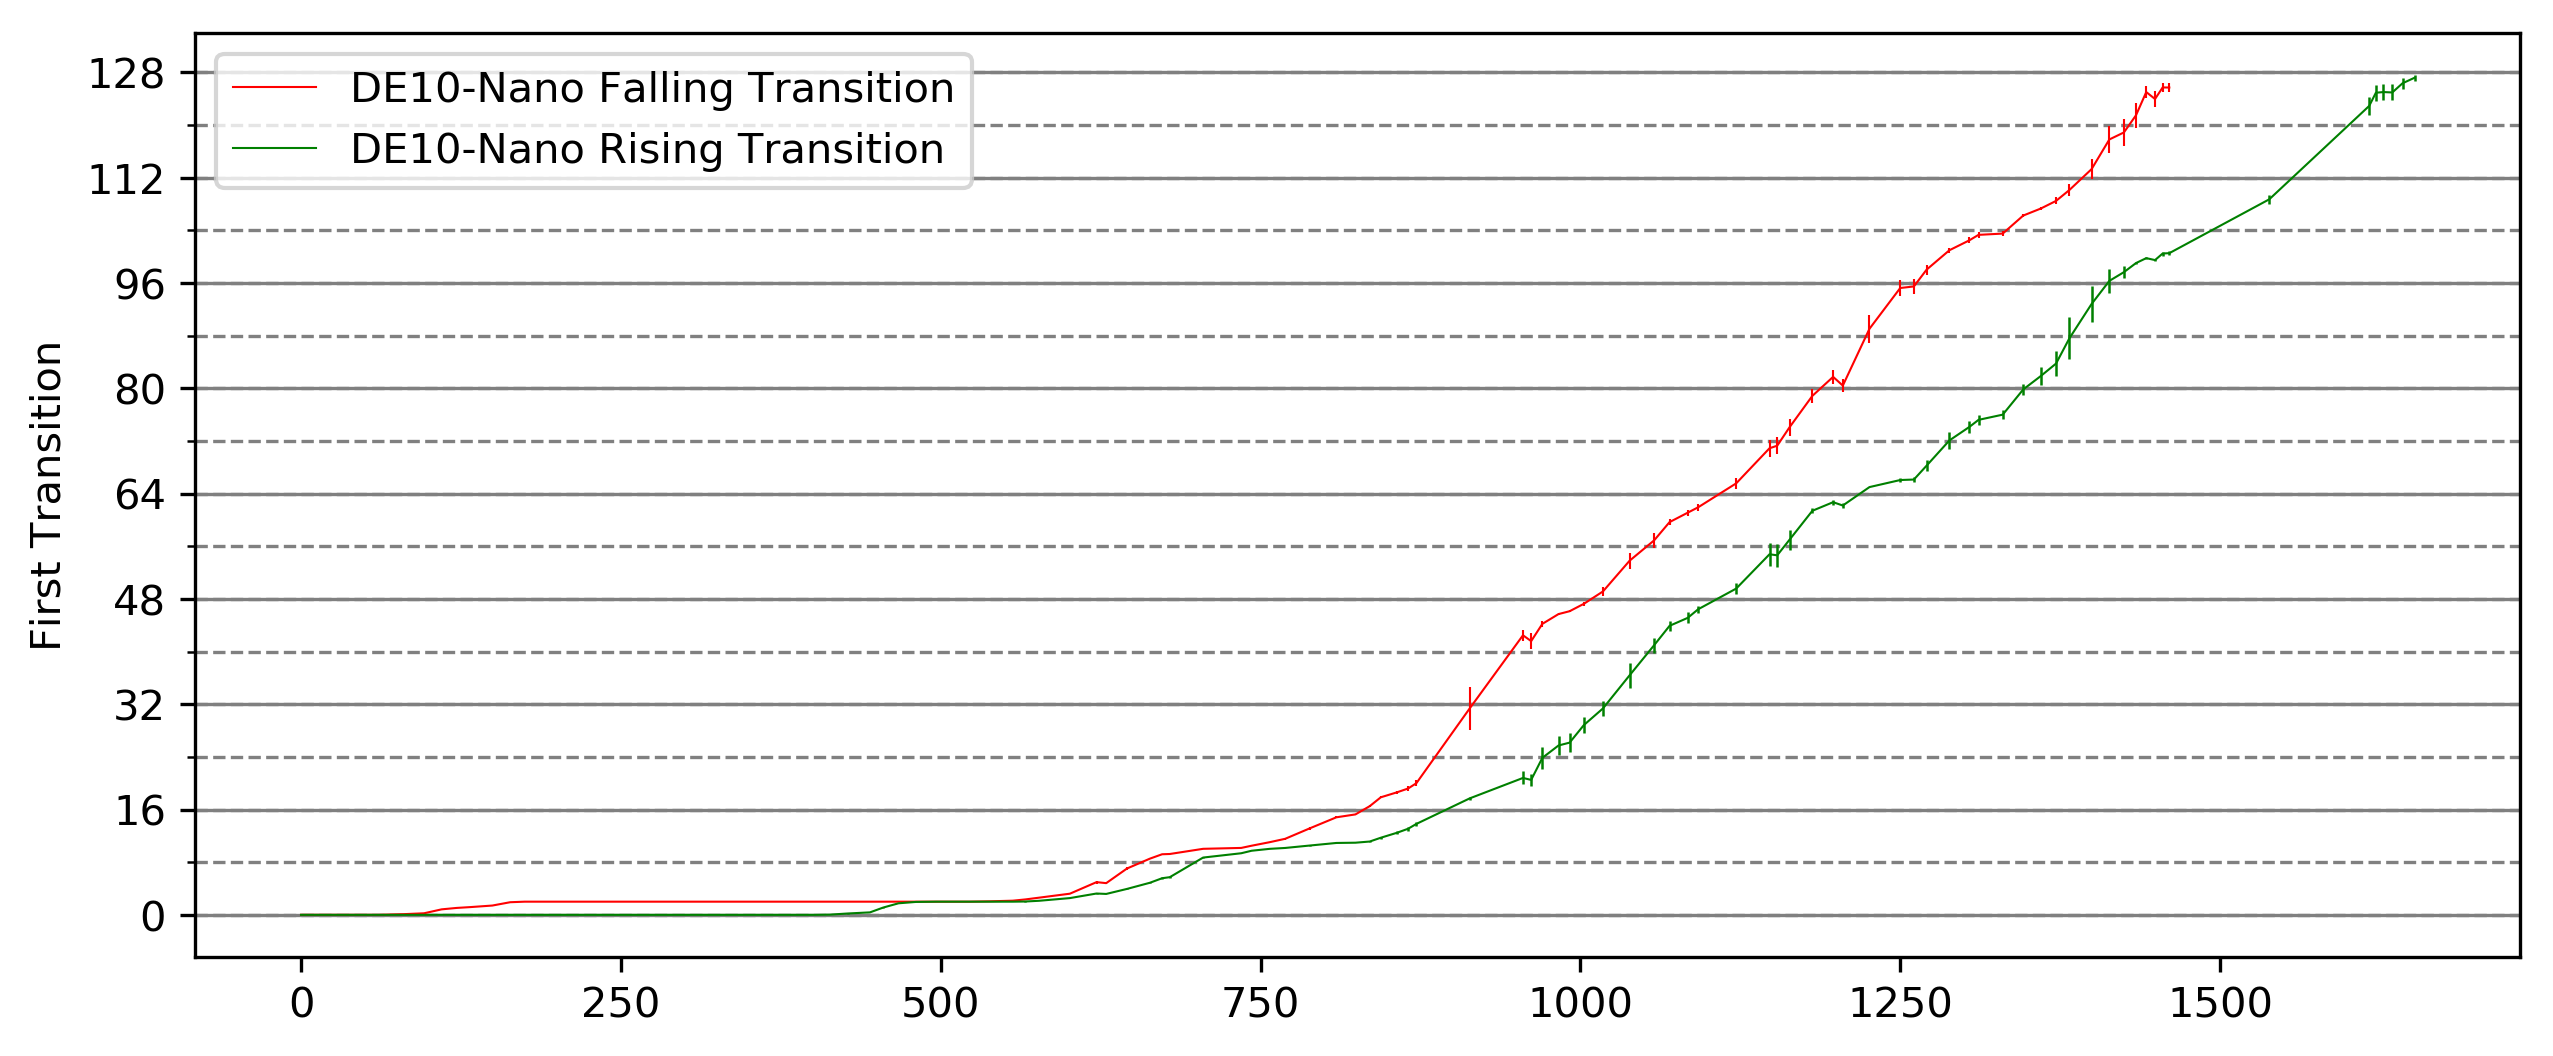

<Figure size 1920x1440 with 0 Axes>

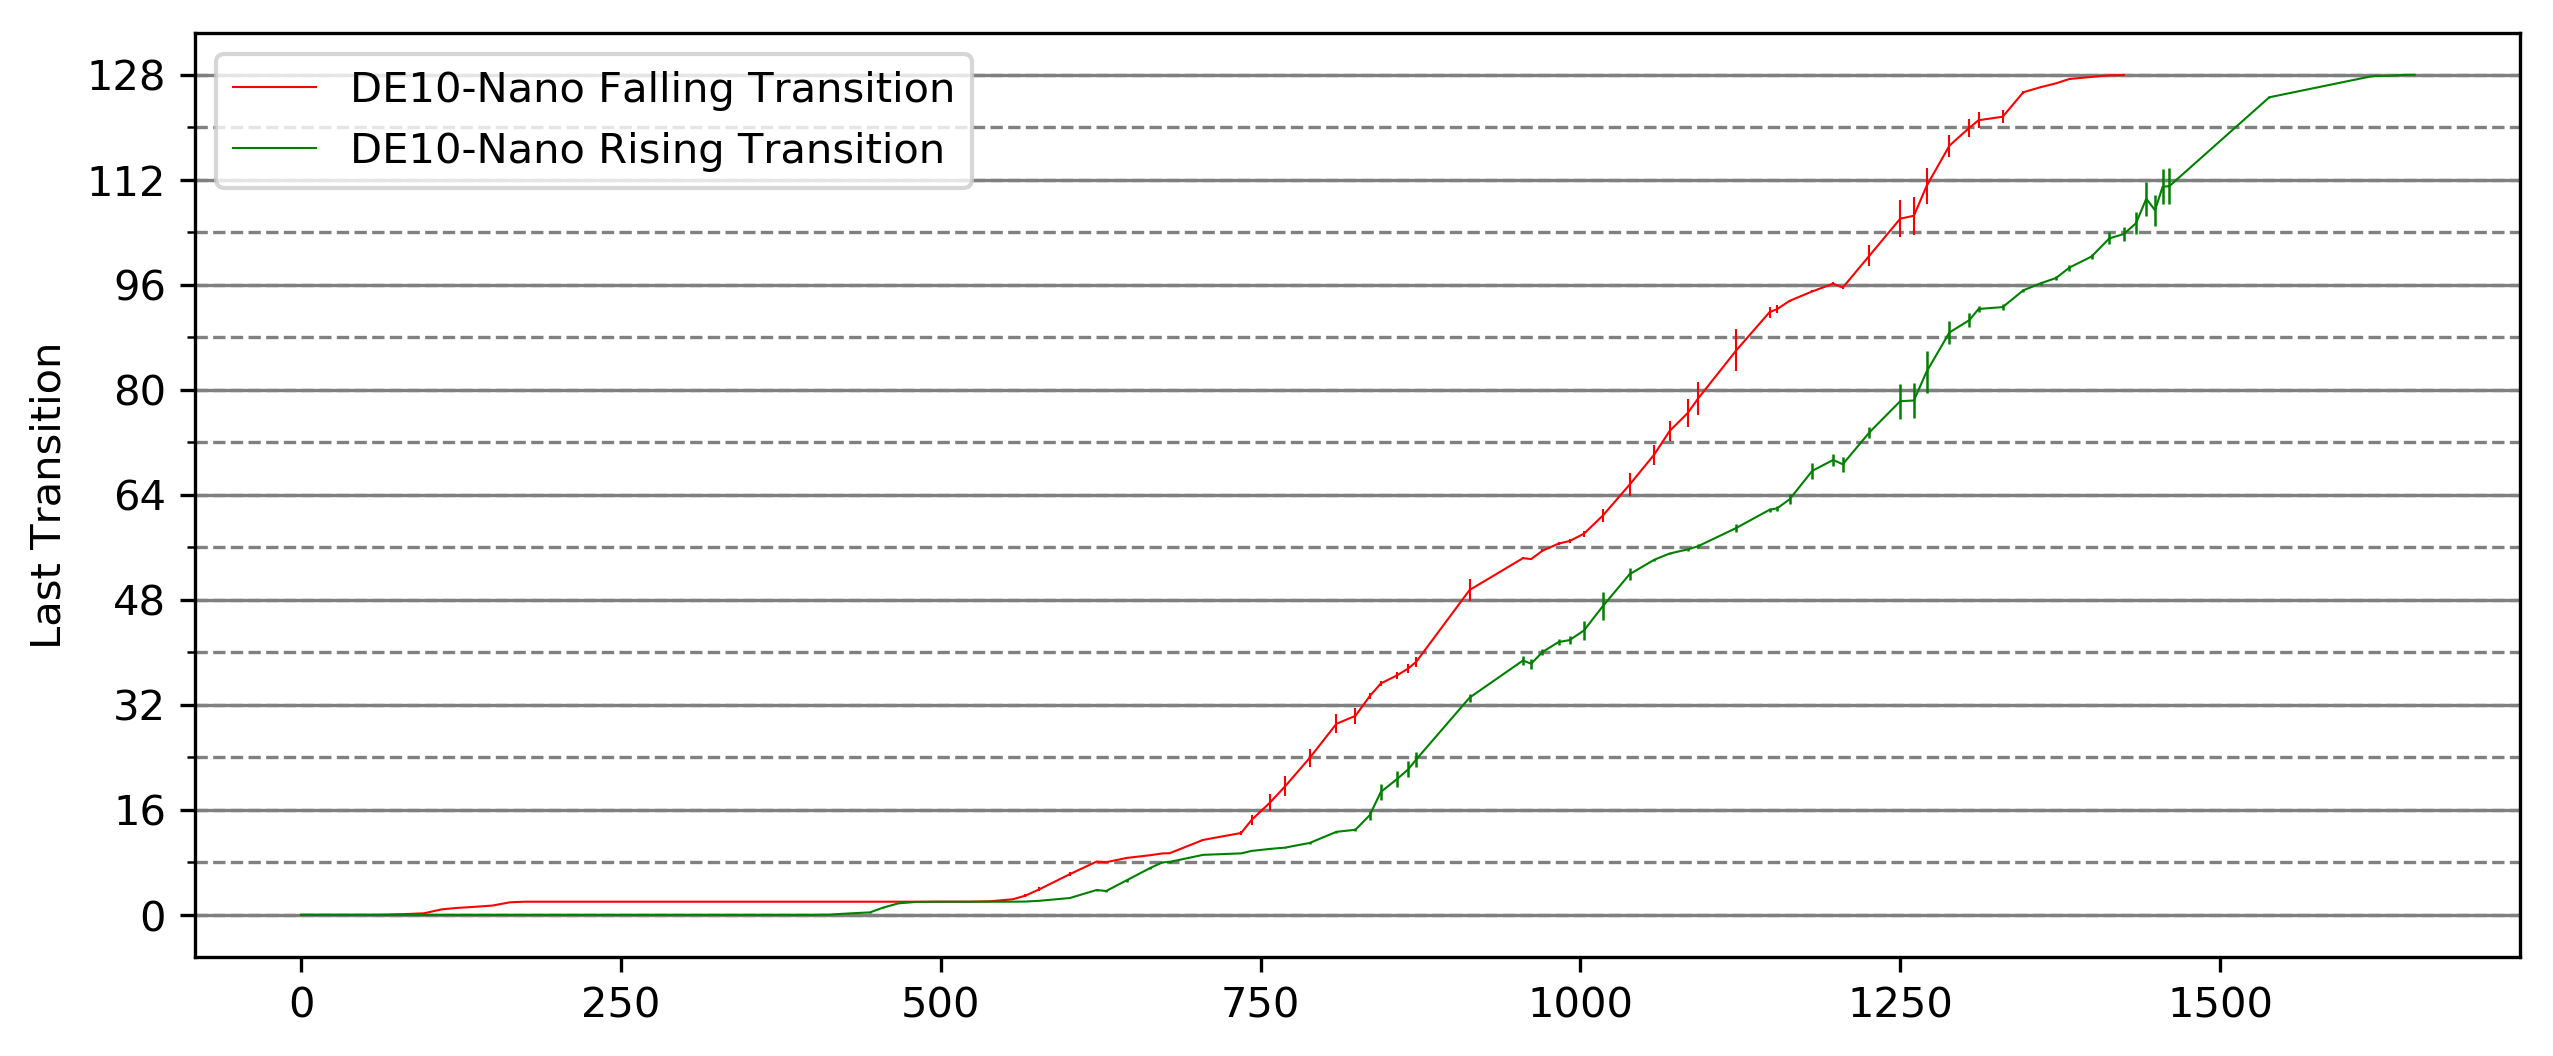

<Figure size 1920x1440 with 0 Axes>

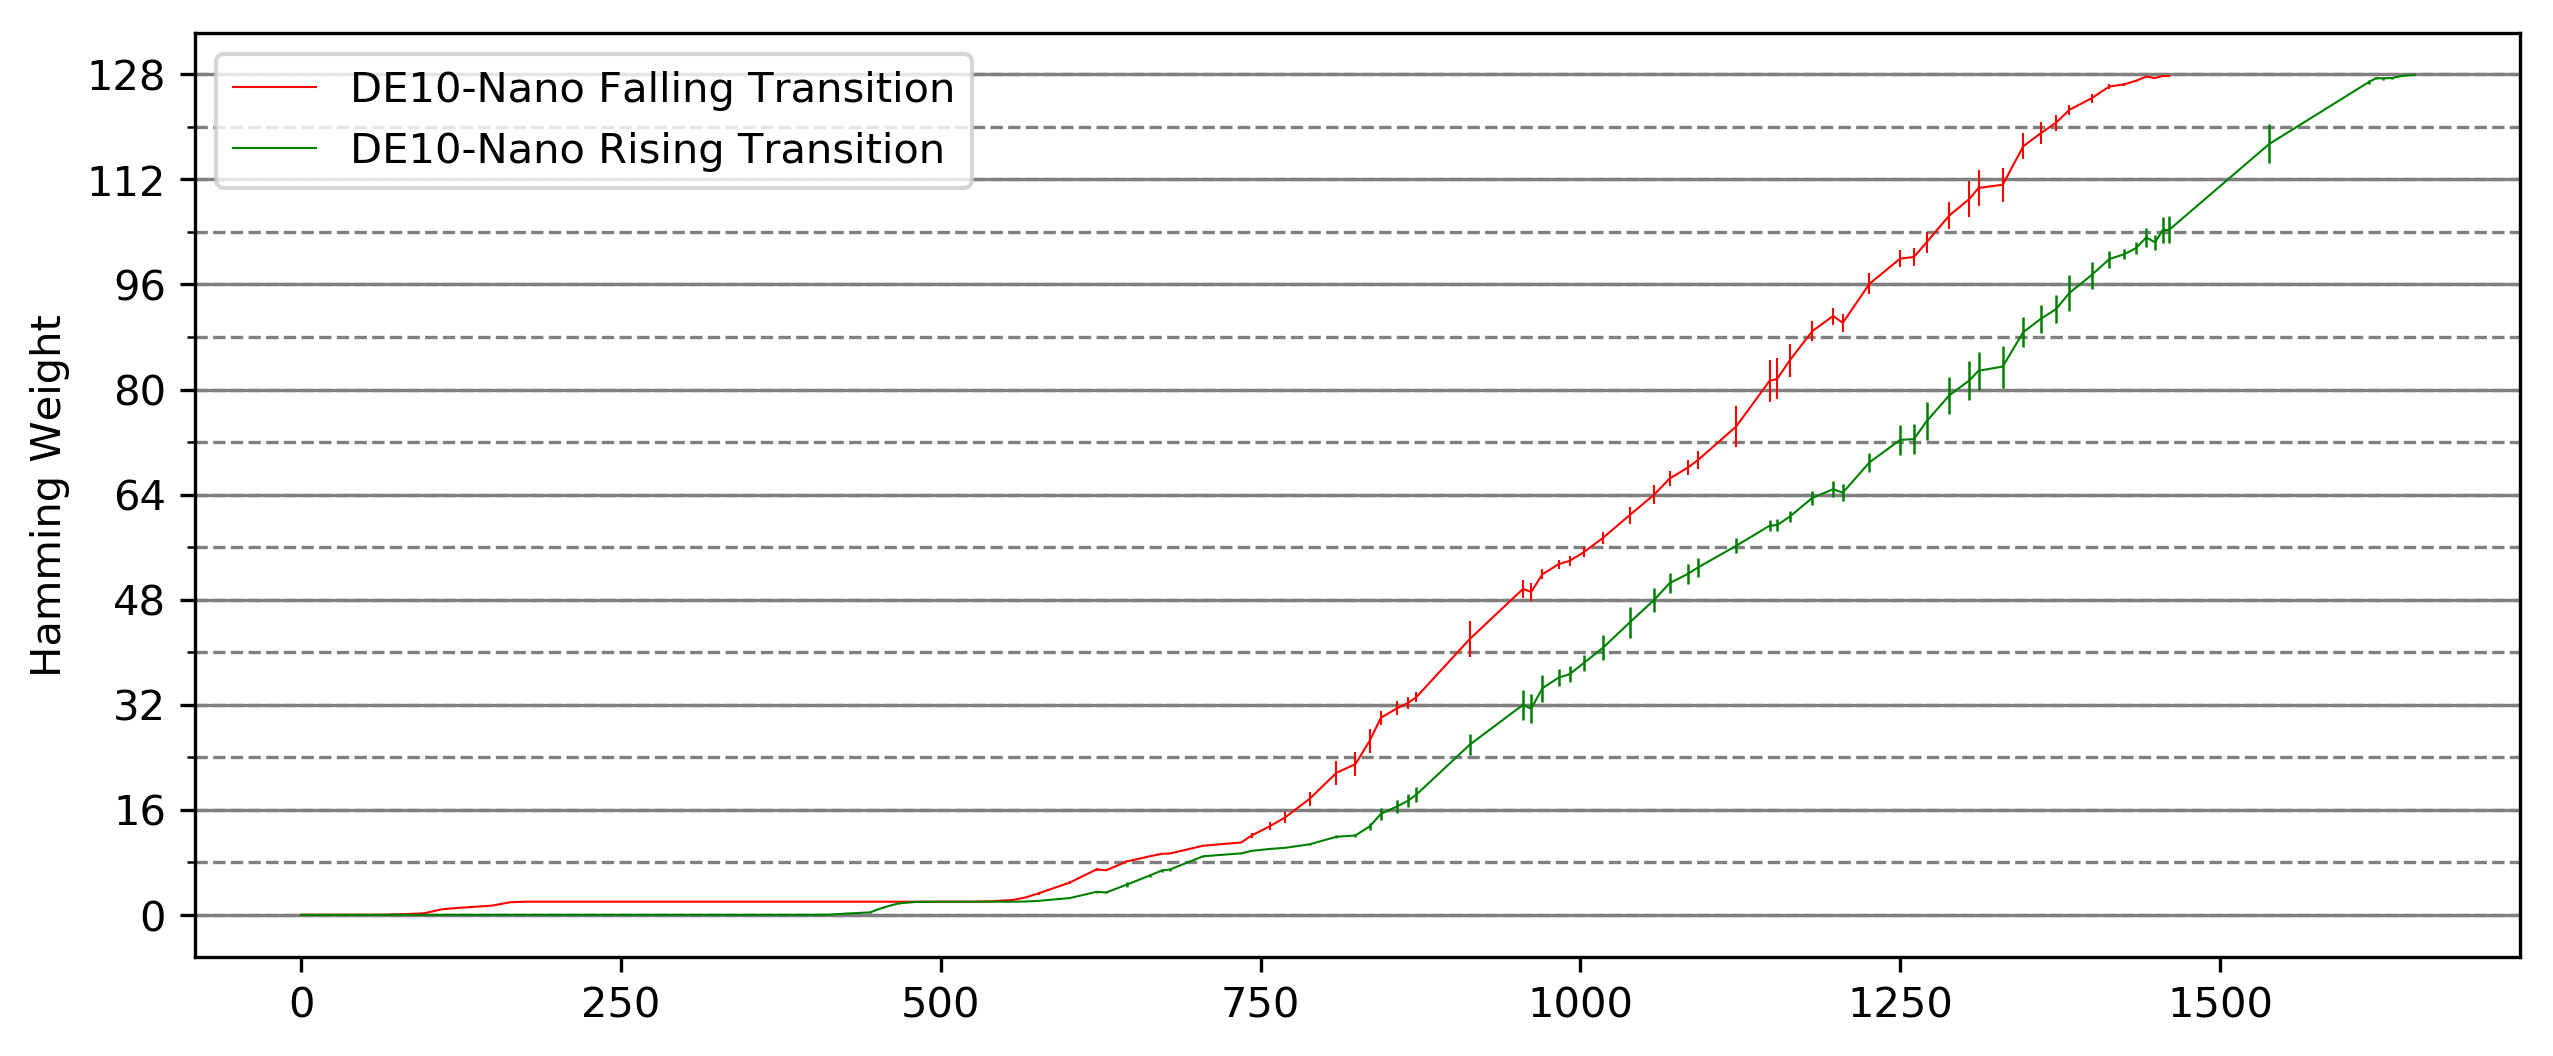

<Figure size 1920x1440 with 0 Axes>

In [9]:
tdc_sweeper.plot_theta_sweep_results("../../../archived_results/data/theta_sweep.csv")